In [8]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_3")
fig_out_dir.mkdir(exist_ok=True, parents=True)

## Load model results

In [ ]:
model_results = pd.read_csv('data/experiment_5_precedence_effects.csv')

## Human data from figure extraction

In [10]:
freyman_human_data = np.array([-11.937626695774213,73.05785123966942,
                            -7.8768127241540675,85.2892561983471,
                            -3.8259784812100452,92.23140495867769,
                            0.17838765008576019,94.54545454545455,
                            -11.99844066739436,40.826446280991746,
                            -7.911429907999382,66.94214876033058,
                            -3.8920941836893856,77.19008264462809,
                            0.09168875721191228,88.59504132231405,
                            -11.95696242008421,42.80991735537191,
                            -7.883050054576644,61.98347107438017,
                            -3.933884297520663,75.04132231404958,
                            0.15874005925463663,84.13223140495867,
                            -12.006237330422584,36.69421487603306,
                            -7.984406673943557,48.26446280991736,
                            -3.9828473413379104,49.0909090909091,
                            0.08794635895836223,66.61157024793388]).reshape(-1,2)

freyman_human_data = pd.DataFrame({'snr':freyman_human_data[:,0], 'accuracy':freyman_human_data[:,1]})
freyman_human_data['diotic_cond'] = ["F-R"] * 4 + ["F-RF"] * 4 + ["F-FR"] * 4 + ["F-F"] * 4
freyman_human_data

,snr,accuracy,diotic_cond
0,-11.937627,73.057851,F-R
1,-7.876813,85.289256,F-R
2,-3.825978,92.231405,F-R
3,0.178388,94.545455,F-R
4,-11.998441,40.826446,F-RF
5,-7.911430,66.942149,F-RF
6,-3.892094,77.190083,F-RF
7,0.091689,88.595041,F-RF
8,-11.956962,42.809917,F-FR
9,-7.883050,61.983471,F-FR


## Summarize main FBA models

In [11]:
# FBA model to plot 
fba_models = model_results[model_results.model.str.contains('main|arch')]
# model level summary 
fba_to_plot = fba_models.groupby(['model', 'dist_lead_channel', 'snr']).agg({'accuracy_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem']}).reset_index()
fba_to_plot.columns =  ['model', 'dist_lead_channel', 'snr', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']



## Run model stats

In [ ]:
from src.util_analysis import bootstrap_partial_eta_ci

fba_model_df = model_results[model_results.model.str.contains('main|arch') & (model_results.gender_cond == 'same')].copy()
fba_model_df = fba_model_df[fba_model_df.dist_lead_channel.isin(["F-RF", 'F-F'])]

anova_table, bootstrap_np2 = bootstrap_partial_eta_ci(
    df=fba_model_df,
    dv_col='accuracy_mean',
    subject_col='model',
    within_factors=["dist_lead_channel", 'snr'],
    n_bootstrap=2000,
)

print("ANOVA for model")
anova_table

Partial η² bootstrap:   0%|          | 0/2000 [00:00<?, ?it/s]

Partial η² bootstrap: 100%|██████████| 2000/2000 [00:59<00:00, 33.37it/s]

ANOVA for model


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps,np2_CI_lower,np2_CI_upper
0,dist_lead_channel,1.046430,1,9,1.046430,1224.917078,6.271680e-11,6.271680e-11,0.992706,1.000000,0.989927,0.996422
1,snr,1.056885,3,27,0.352295,4757.049096,7.180385e-37,4.161443e-22,0.998112,0.576976,0.997510,0.999083
2,dist_lead_channel * snr,0.007203,3,27,0.002401,45.262331,1.146856e-10,4.941129e-07,0.834139,0.585376,0.800453,0.899712


### Plot summarized model result against humans 

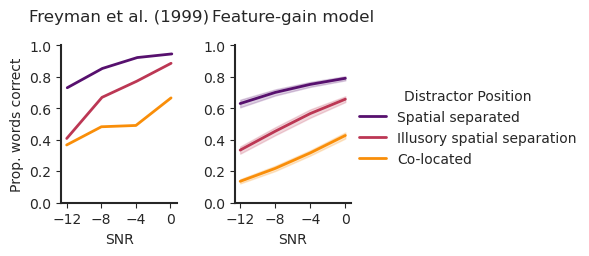

In [13]:
hue_order = ['F-R',  "F-RF",'F-F']

# rename dist_lead_channel names 
name_map = {'F-R':'Spatial separated', 'F-RF':'Illusory spatial separation', 'F-F':'Co-located'}
hue_order = [name_map[x] for x in hue_order]



sns.set_style('ticks')


model_to_plot = fba_to_plot.copy() 
model_to_plot['group'] = 'Feature-gain model'

human_to_plot = freyman_human_data.copy()

# merge model_to_plot with human data
human_to_plot['model'] = 'Freyman et al. (1999)'
human_to_plot['group'] = 'Freyman et al. (1999)'
human_to_plot['dist_lead_channel'] = human_to_plot['diotic_cond'] 
human_to_plot['accuracy'] = human_to_plot['accuracy']/100

data_to_plot = pd.concat([model_to_plot, human_to_plot], axis=0)

data_to_plot['dist_lead_channel'] = data_to_plot['dist_lead_channel'].map(name_map)


g = sns.relplot(data=data_to_plot, x='snr', y='accuracy',
            col='group', col_order=['Freyman et al. (1999)', 'Feature-gain model'],
            hue='dist_lead_channel', kind='line',
            palette='inferno',hue_order=hue_order,
            errorbar=('se', 2),
            height=2.5, linewidth=2, aspect=0.8, legend=True,
            facet_kws={'sharey': False, 'sharex': False}
)

g.set(yticks=np.arange(0,  1.1, .20), xticks=np.arange(-12,  1, 4))
# set titles
g.set_titles("{col_name}", size=12, y=1.1)
# set axis labels
g.set_axis_labels("SNR", "Prop. words correct")
# set legend title
g._legend.set_title("Distractor Position")
# add w space
g.fig.subplots_adjust(wspace=.5)
# thicken axis lines
for ax in g.axes.flat:
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
# don't share y ticks

# plt.savefig(fig_out_dir/'experiment_5_precedence_effect.pdf', transparent=True, bbox_inches='tight')
